# OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction

[kaggle competition site](https://www.kaggle.com/c/stanford-covid-vaccine) 

Dataset description:
- train set:                    2400 examples of length=107 and scoring_length=68
- public test set:              629  examples of length=107 and scoring_length=68 + 3005 examples of length=130 and scoring_length=91
- private leaderboard test set: 3005 examples of length=130 and scoring_length=91 OR same as public test set ????????????????????

### TODO:
- no testing model, one model with different testing and training outputs
- augmentation
- przewidywanie dalszego fragmentu sekwencji na podstawie wczesiejszego fragmentu sekwencji
- GCN
- sequence fragmentation and similarieties finding

## Import section

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Concatenate, Lambda, Bidirectional, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

import spektral
from spektral.layers import GraphConv, GraphAttention, GlobalAttentionPool

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import joypy

import os
import json
import uuid
import copy
import random

In [56]:
from data_preparation import *
from submit import create_submission

In [3]:
%load_ext tensorboard

In [4]:
%load_ext autoreload
%autoreload 2

from ipynb.draw import draw_struct

# Data Loading

In [8]:
raw_train_valid_ds, raw_public_test_ds, raw_private_test_ds = get_raw_datasets()

### Data inspection

In [9]:
def raw_ds_summary(raw_ds):
    print('EXAMPLES:')
    display(raw_ds.head())
    print()
    print('SIMPLE STATISTICS:')
    display(raw_ds.describe())
    print()
    print('POSSIBLE SEQUENCES LENGTHS')
    display(raw_ds[['seq_length', 'seq_scored']].drop_duplicates())

In [10]:
print('RAW_TRAIN_VALID_DATASET')
raw_ds_summary(raw_train_valid_ds)

RAW_TRAIN_VALID_DATASET
EXAMPLES:


,index,id,sequence,structure,adjacency_matrix,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0


SIMPLE STATISTICS:


,index,signal_to_noise,SN_filter,seq_length,seq_scored
count,2400.000000,2400.000000,2400.000000,2400.0,2400.0
mean,1199.500000,4.530456,0.662083,107.0,68.0
std,692.964646,2.835142,0.473099,0.0,0.0
min,0.000000,-0.103000,0.000000,107.0,68.0
25%,599.750000,2.391000,0.000000,107.0,68.0
50%,1199.500000,4.442500,1.000000,107.0,68.0
75%,1799.250000,6.294250,1.000000,107.0,68.0
max,2399.000000,17.194000,1.000000,107.0,68.0



POSSIBLE SEQUENCES LENGTHS


,seq_length,seq_scored
0,107,68


In [13]:
print('RAW_PUBLIC_TEST_DATASET')
raw_ds_summary(raw_public_test_ds)

RAW_PUBLIC_TEST_DATASET
EXAMPLES:


,index,id,sequence,structure,adjacency_matrix,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
18,18,id_00ca60e44,GGAAAGCAGGAGGCCGAGGAUCCUGCGCUAUGAGGAAACCAUAGAC...,.....((.((.((.((.(((((((((((((((.(....)))))).)...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSBSSISSISSISSSSSSSSSSSSSSSBSHHHHSSSSSSBS...,107,68
23,23,id_00e99b69c,GGAAAUUUUAGAUUGCACACAGUCAGGUAGUUAAAAUUAGGCCACC...,..........(((((....)))))((((.(((....(((((........,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEEEEEESSSSSHHHHSSSSSSSSSISSSIIIISSSSSHHHHH...,107,68



SIMPLE STATISTICS:


,index,seq_length,seq_scored
count,629.000000,629.0,629.0
mean,1798.036566,107.0,68.0
std,1043.635572,0.0,0.0
min,0.000000,107.0,68.0
25%,870.000000,107.0,68.0
50%,1851.000000,107.0,68.0
75%,2683.000000,107.0,68.0
max,3627.000000,107.0,68.0



POSSIBLE SEQUENCES LENGTHS


,seq_length,seq_scored
0,107,68


In [12]:
print('RAW_PRIVATE_TEST_DATASET')
raw_ds_summary(raw_private_test_ds)

RAW_PRIVATE_TEST_DATASET
EXAMPLES:


,index,id,sequence,structure,adjacency_matrix,predicted_loop_type,seq_length,seq_scored
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91
5,5,id_002852873,GGAAAGCGAAACGCCGAGAAGACGUAGUUCGCAGAGCGGCGUACCC...,.....(((...(((......(((((((((.((....(((.....))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSIIISSSBBBBBBSSSSSSSSSBSSBBBBSSSHHHHHSS...,130,91
6,6,id_0031191b7,GGAAAUGUCUACAUAGGAGUGCUGCGGGACGGUAACGUCAUGACCG...,........(((((((((((.((..(((((((....))))....)))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEEEESSSSSSSSSSSISSIISSSSSSSHHHHSSSSBBBBSSS...,130,91
7,7,id_003ab2445,GGAAAGACUCAGAGGUGAAGGUCAUCACGGCUGAUAGGAGACUAUC...,.....(((((..........((((((.((.(((((((....)))))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSBBBBBBBBBBSSSSSSISSISSSSSSSHHHHSSSSS...,130,91



SIMPLE STATISTICS:


,index,seq_length,seq_scored
count,3005.000000,3005.0,3005.0
mean,1820.364725,130.0,91.0
std,1050.480524,0.0,0.0
min,1.000000,130.0,91.0
25%,911.000000,130.0,91.0
50%,1808.000000,130.0,91.0
75%,2732.000000,130.0,91.0
max,3633.000000,130.0,91.0



POSSIBLE SEQUENCES LENGTHS


,seq_length,seq_scored
1,130,91


In [14]:
sample_submission = get_sample_submission()
sample_submission

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
457948,id_ffda94f24_125,0.0,0.0,0.0,0.0,0.0
457949,id_ffda94f24_126,0.0,0.0,0.0,0.0,0.0
457950,id_ffda94f24_127,0.0,0.0,0.0,0.0,0.0
457951,id_ffda94f24_128,0.0,0.0,0.0,0.0,0.0


### Error analysis

In [15]:
def ploterrors(example):
    plots_no = len(NORMAL_LABEL_NAMES)
    plot_width= 5
    plot_height = 5
    fig, axes = plt.subplots(1,5,figsize=(plot_width*plots_no,plot_height))

    for i, ax in enumerate(axes.flat):
        y = example[NORMAL_LABEL_NAMES[i]]
        x = range(len(y))
        dy = example[ERROR_LABEL_NAMES[i]]
        ax.errorbar(x, y, yerr=dy, fmt='.k', ecolor='gray')

In below grid of charts, each row represent single random chosen example. Each column is associated with one label (from normal_label_names list and also in the same order).

In each chart:
* black points means example label values for each RNA base
* grey lines means measurement errors

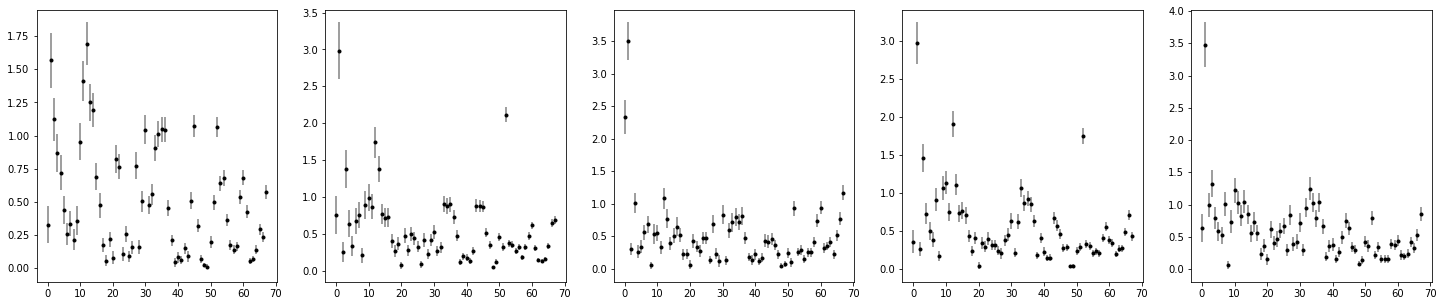

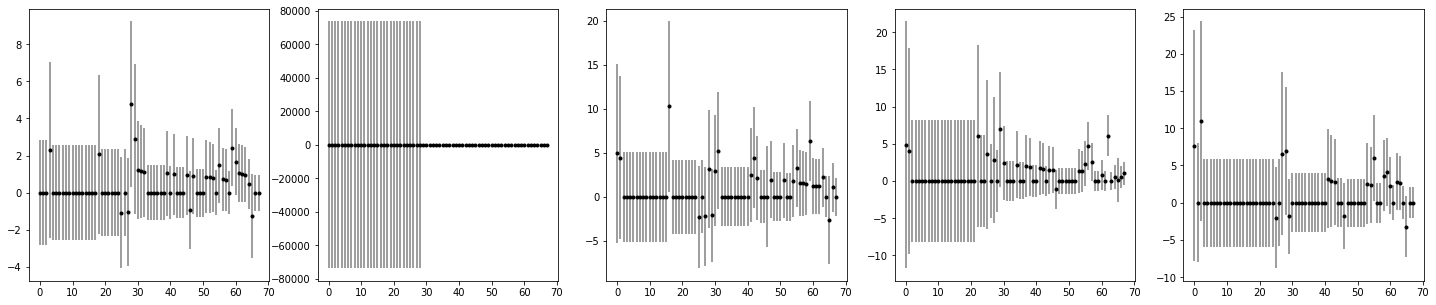

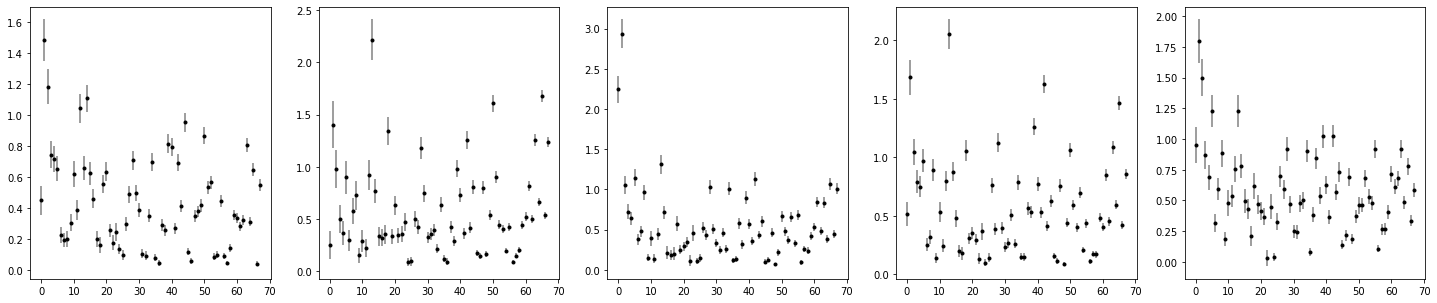

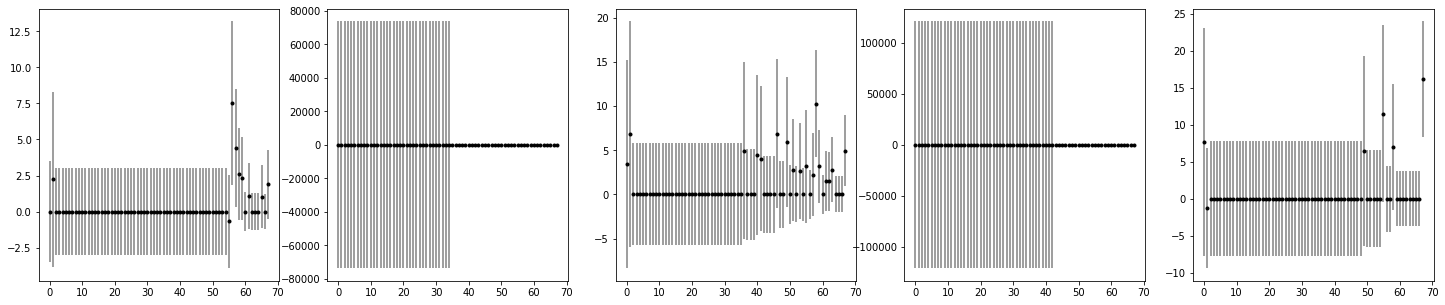

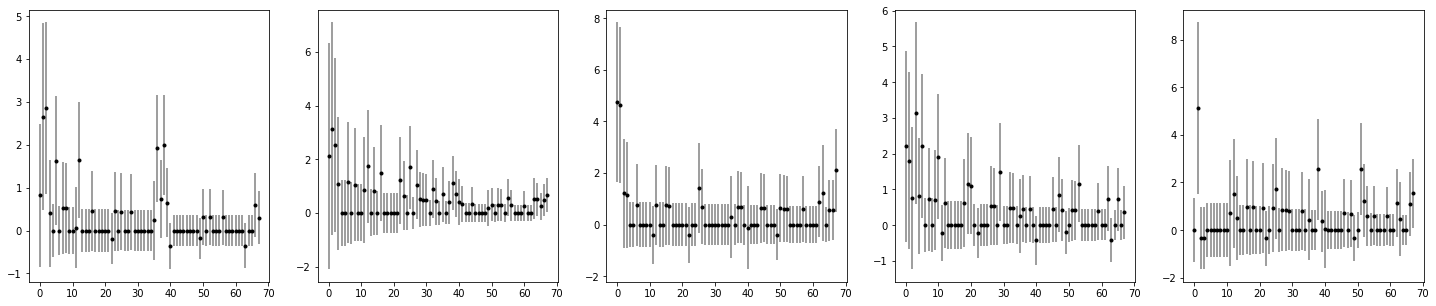

In [16]:
for i in range(5):
    ploterrors(raw_train_valid_ds.loc[i])

We can see that some examples have unnormal big measurement errors, so let's see median (not mean, because it's sensitive to outliers) measurements errors for each RNA base in each label across all examples.

In [17]:
def plot_median_errors(raw_ds):
    plots_no = len(ERROR_LABEL_NAMES)
    plot_width= 5
    plot_height = 5
    fig, axes = plt.subplots(1,5,figsize=(plot_width*plots_no,plot_height))

    for i, ax in enumerate(axes.flat):
        column = raw_ds[ERROR_LABEL_NAMES[i]]
        x = np.array(column.values.tolist())
        medians = np.median(x, axis=0)
        ax.scatter(range(len(medians)), medians)

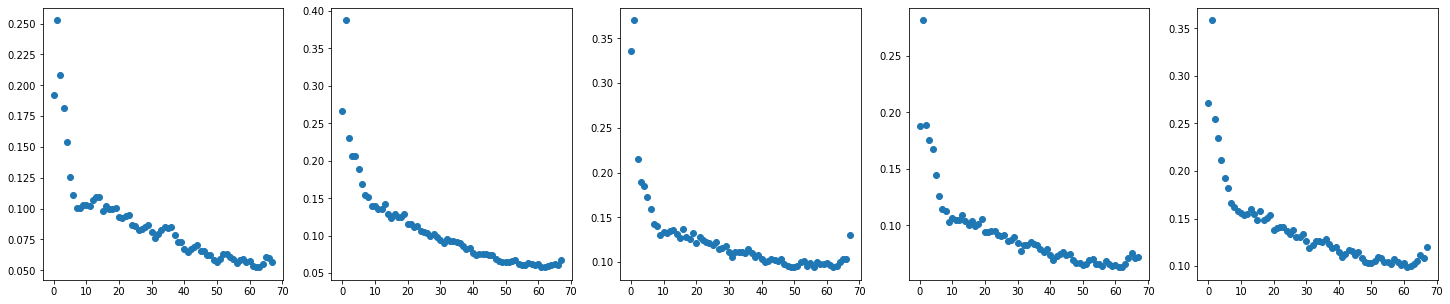

In [18]:
plot_median_errors(raw_train_valid_ds)

We can observe that higher index bases have generaly much lower measurement error

To have greater insight in measurement errors for each bases and for each label across all examples let's see histograms (without outliers)

In [19]:
def max_for_cut_index(x, cut_index, the_range):
    the_max = 0
    index = -200
    for i in range(the_range):
        new_max = x[i][cut_index]
        if new_max > the_max:
            the_max = new_max
    return the_max

In [20]:
def find_cut_index(x, outlier_threshold):
    'input is transposed x'
    bases_range = x.shape[0]
    i_min = 0
    i_max = x.shape[1]
    while True:
        if i_min + 1 >= i_max:
            return i_min
        
        index_to_check = int((i_max + i_min)/2)
        found_val = max_for_cut_index(x, index_to_check, bases_range)
        
        if found_val > outlier_threshold:
            i_max = index_to_check
        else:
            i_min = index_to_check

In [21]:
def plot_errors_dist(raw_ds, error_label_name, outliers_threshold):
    # Get and prepare data
    column = raw_ds[error_label_name]
    x = np.array(column.values.tolist())
    x = np.transpose(x)
    x = np.array([sorted(base) for base in x])
    
    # Calculate
    original_data_size = x.shape[0]*x.shape[1]
    cut_index = find_cut_index(x, outliers_threshold)
    x = x[:,:cut_index]
    cutted_data_size = x.shape[0]*x.shape[1]
    
    data_percentage = cutted_data_size/original_data_size*100

    df = pd.DataFrame()
    for base_index in range(x.shape[0]):
        df[base_index] = x[base_index]
    f, _ = joypy.joyplot(df, overlap=2, colormap=cm.OrRd_r, linecolor='black', linewidth=0.5, fade=True, figsize=(5,12),
                      title=f"{error_label_name} distributions for bases across all examples (without examples containing outlier for even one base - {data_percentage:.2f}% of data)")

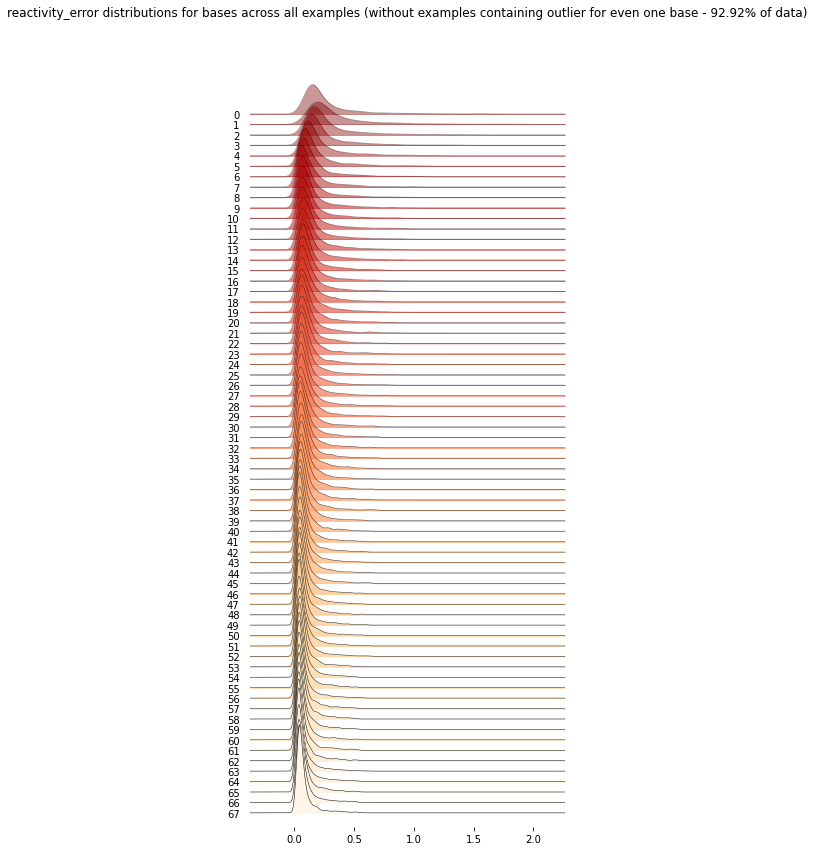

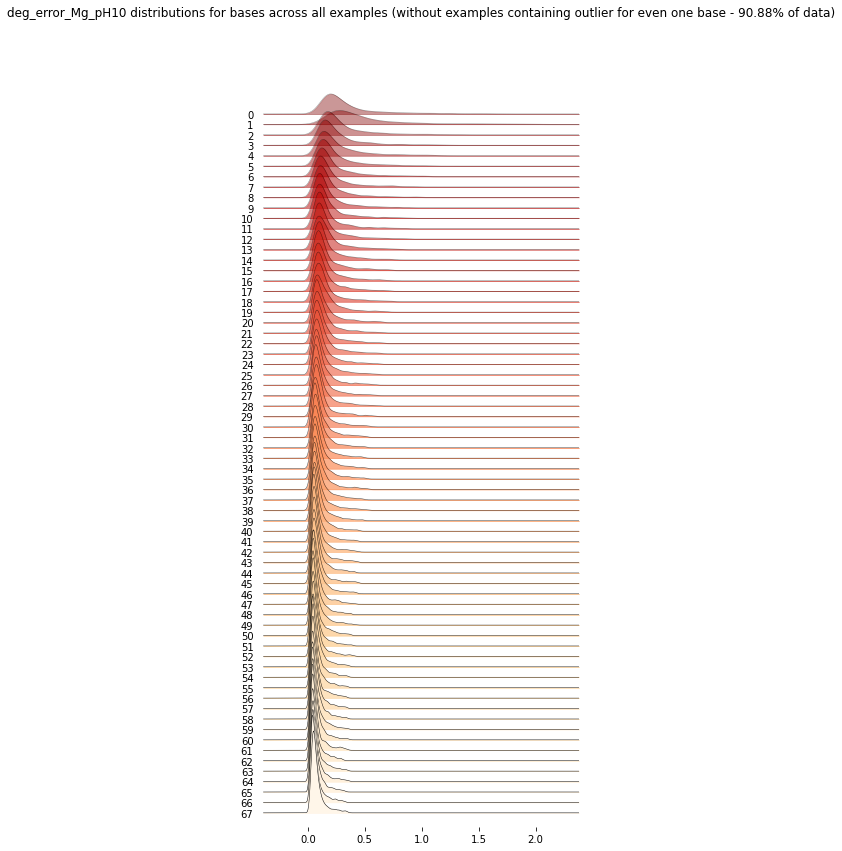

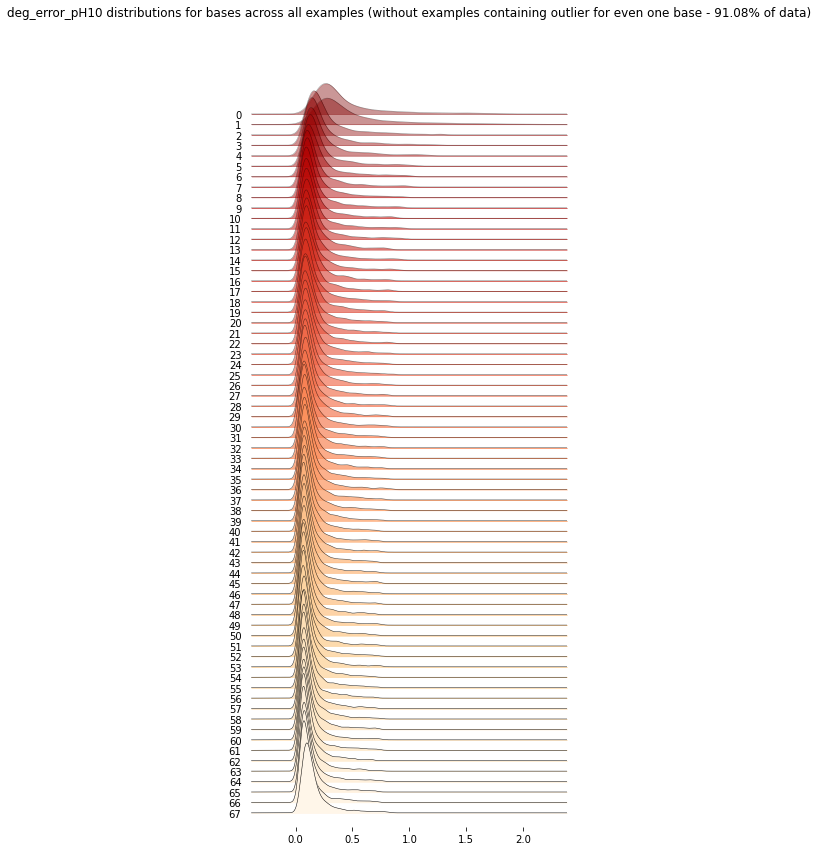

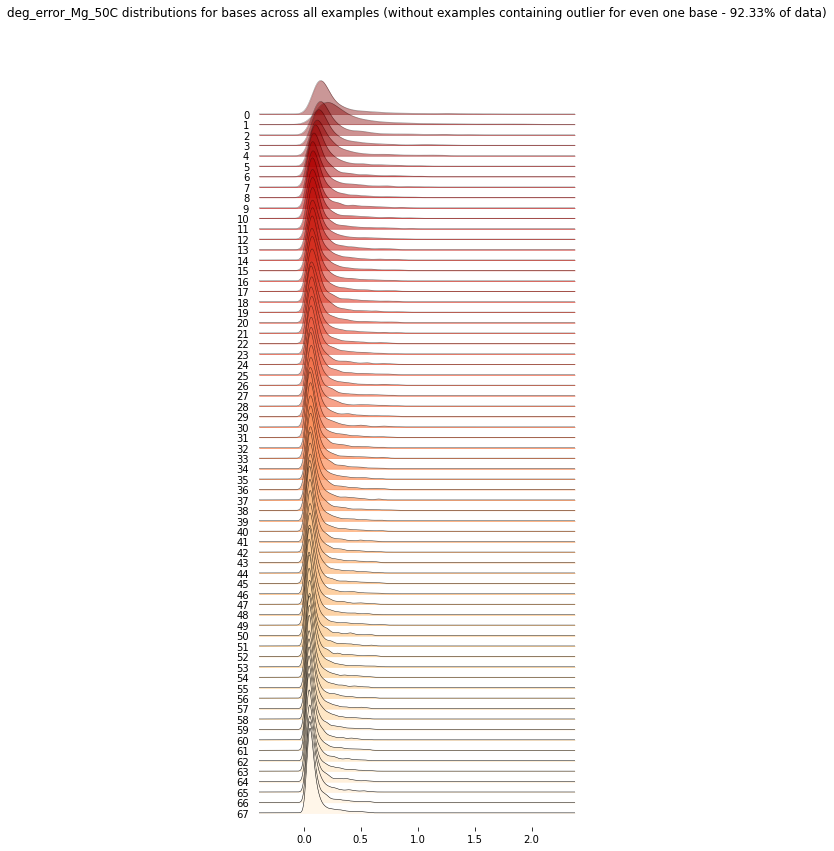

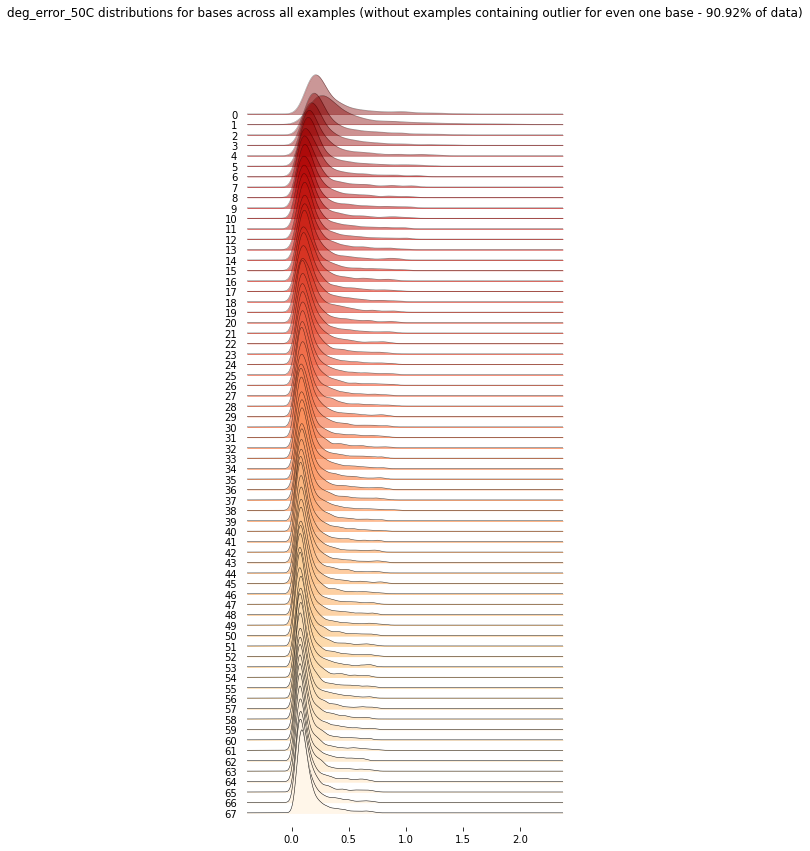

In [22]:
for error_label_name in ERROR_LABEL_NAMES:
    plot_errors_dist(raw_train_valid_ds, error_label_name, 2)

### Labels analysis

In [23]:
def visualize_column(column):
    x = np.array(column.values.tolist())
    df = pd.DataFrame(x)
    display(df.describe())
    fig, axes = joypy.joyplot(df, overlap=2, colormap=cm.OrRd_r, linecolor='black', linewidth=0.5, fade=True, figsize=(24,12))
    plt.show(fig)

reactivity


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.536378,1.513710,1.124513,0.833669,0.672602,0.458567,0.360533,0.298208,0.292377,0.293193,...,0.320005,0.305114,0.299979,0.306304,0.311137,0.303148,0.334632,0.403904,0.360276,0.324275
std,0.729612,1.266217,1.349776,1.729040,0.689051,0.517758,0.747417,0.672364,0.450488,0.434571,...,0.588476,0.658501,0.735699,0.479715,0.720027,0.707542,0.628050,0.658385,0.648611,0.957559
min,-20.664800,-20.664800,-20.660600,-20.660600,-20.664800,-10.333900,-20.664800,-20.664800,-4.631400,-3.444700,...,-3.444600,-20.664800,-20.664800,-1.879000,-20.664800,-6.889200,-1.367700,-2.583500,-20.664800,-20.664800
25%,0.323375,0.956700,0.845600,0.613825,0.297775,0.110100,0.062375,0.032875,0.028675,0.032075,...,0.041700,0.038450,0.040600,0.029575,0.032400,0.040600,0.037475,0.056200,0.098200,0.109475
50%,0.504150,1.383450,1.154650,0.873850,0.597150,0.333350,0.235750,0.163700,0.179550,0.181450,...,0.200000,0.185450,0.200650,0.154150,0.150250,0.167850,0.203850,0.264150,0.280450,0.235450
75%,0.737650,1.918000,1.456175,1.147125,0.981700,0.725525,0.507100,0.433725,0.424325,0.444050,...,0.489025,0.482675,0.476450,0.472625,0.456850,0.412375,0.485675,0.638125,0.516800,0.412200
max,20.664800,20.666800,20.664800,20.664800,5.167100,5.167100,20.664800,10.333400,4.769700,9.152900,...,20.664800,13.778400,20.664800,10.333900,13.778400,20.664800,20.664800,20.664800,10.333400,20.664800


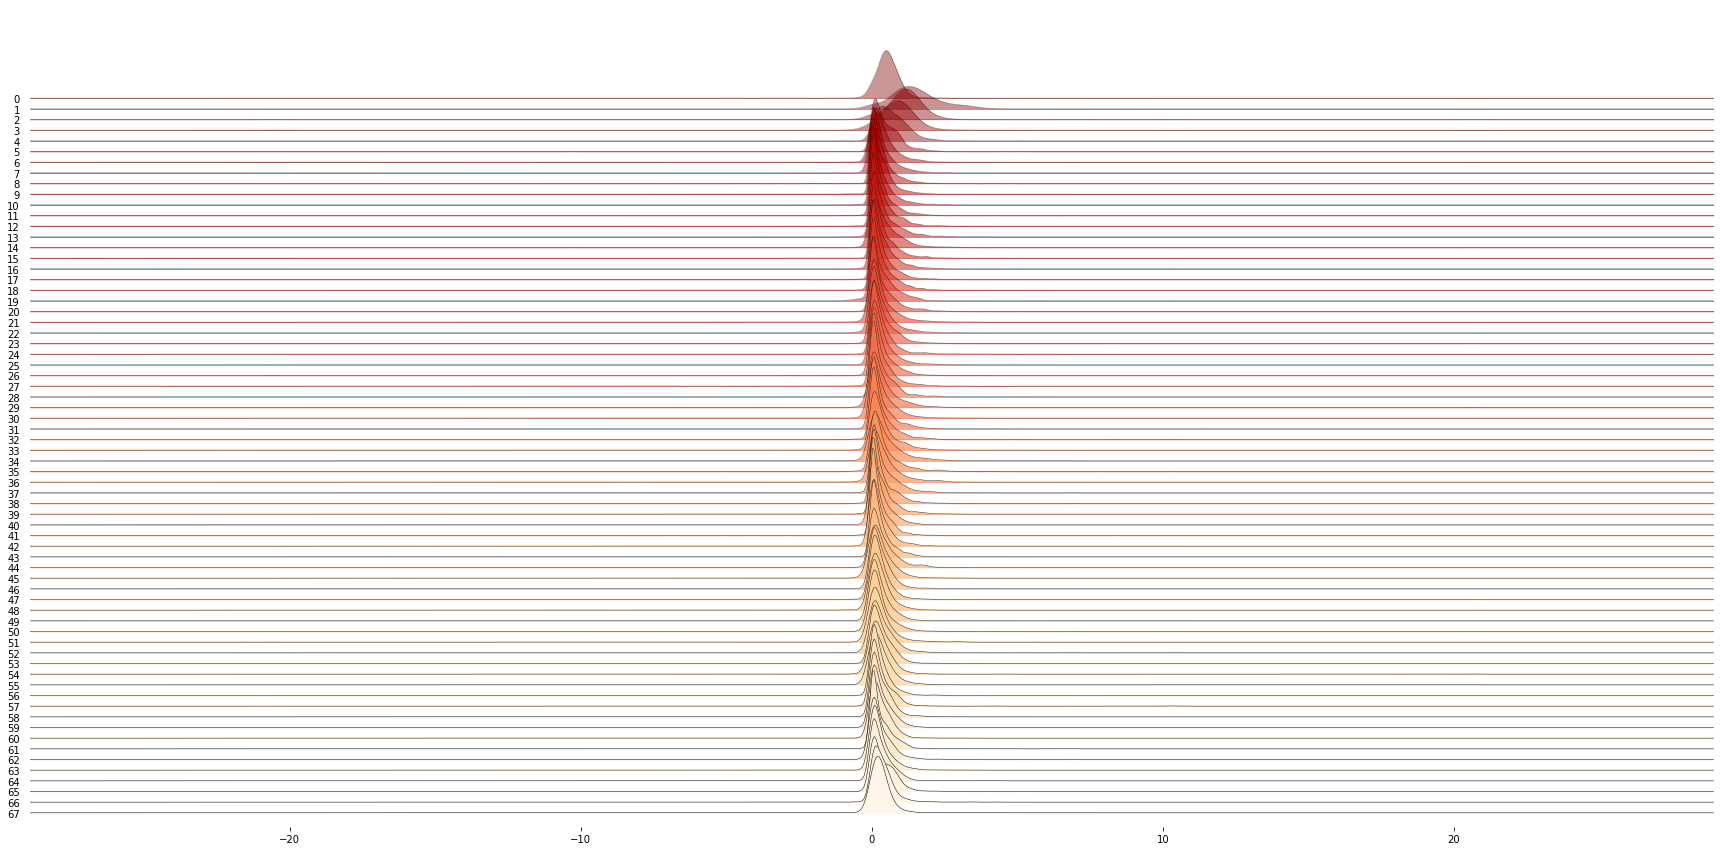

deg_Mg_pH10


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.594784,2.089024,0.722305,0.550928,0.695129,0.589534,0.515086,0.411426,0.428095,0.368775,...,0.437803,0.395689,0.446379,0.426576,0.419822,0.516840,0.597314,0.577760,0.498237,0.673022
std,0.634141,1.445612,0.951488,1.272770,1.044889,0.738532,0.711125,0.751521,0.573831,0.585195,...,0.634314,0.490042,0.690477,0.489091,0.606020,0.633568,0.811998,0.756932,0.599616,0.691804
min,-14.738100,-14.738100,-14.735200,-14.738100,-14.740500,-7.370400,-14.738100,-14.738100,-4.738100,-2.456800,...,-1.473900,-9.824800,-14.738100,-0.685600,-13.264100,-4.913400,-1.842600,-0.781700,-14.738100,-14.738100
25%,0.350075,1.272700,0.351800,0.331525,0.302275,0.219450,0.174875,0.126800,0.128150,0.117775,...,0.137625,0.151325,0.150350,0.160550,0.141650,0.193050,0.201375,0.214600,0.255000,0.365775
50%,0.562200,1.883700,0.703900,0.541000,0.529700,0.448250,0.375650,0.293650,0.290250,0.269650,...,0.279350,0.287350,0.305900,0.293750,0.285950,0.342750,0.373450,0.400750,0.404250,0.574250
75%,0.807500,2.776950,1.030675,0.784225,0.931650,0.837650,0.685650,0.560775,0.580900,0.490425,...,0.566400,0.521250,0.559900,0.533075,0.513175,0.648450,0.685800,0.726300,0.613000,0.860450
max,14.735200,14.739600,14.735200,14.738100,7.370200,14.738100,14.738100,14.739100,4.913400,14.738100,...,14.738100,7.369800,14.739600,7.369800,7.370200,14.740100,14.739600,14.738100,7.369800,7.369800


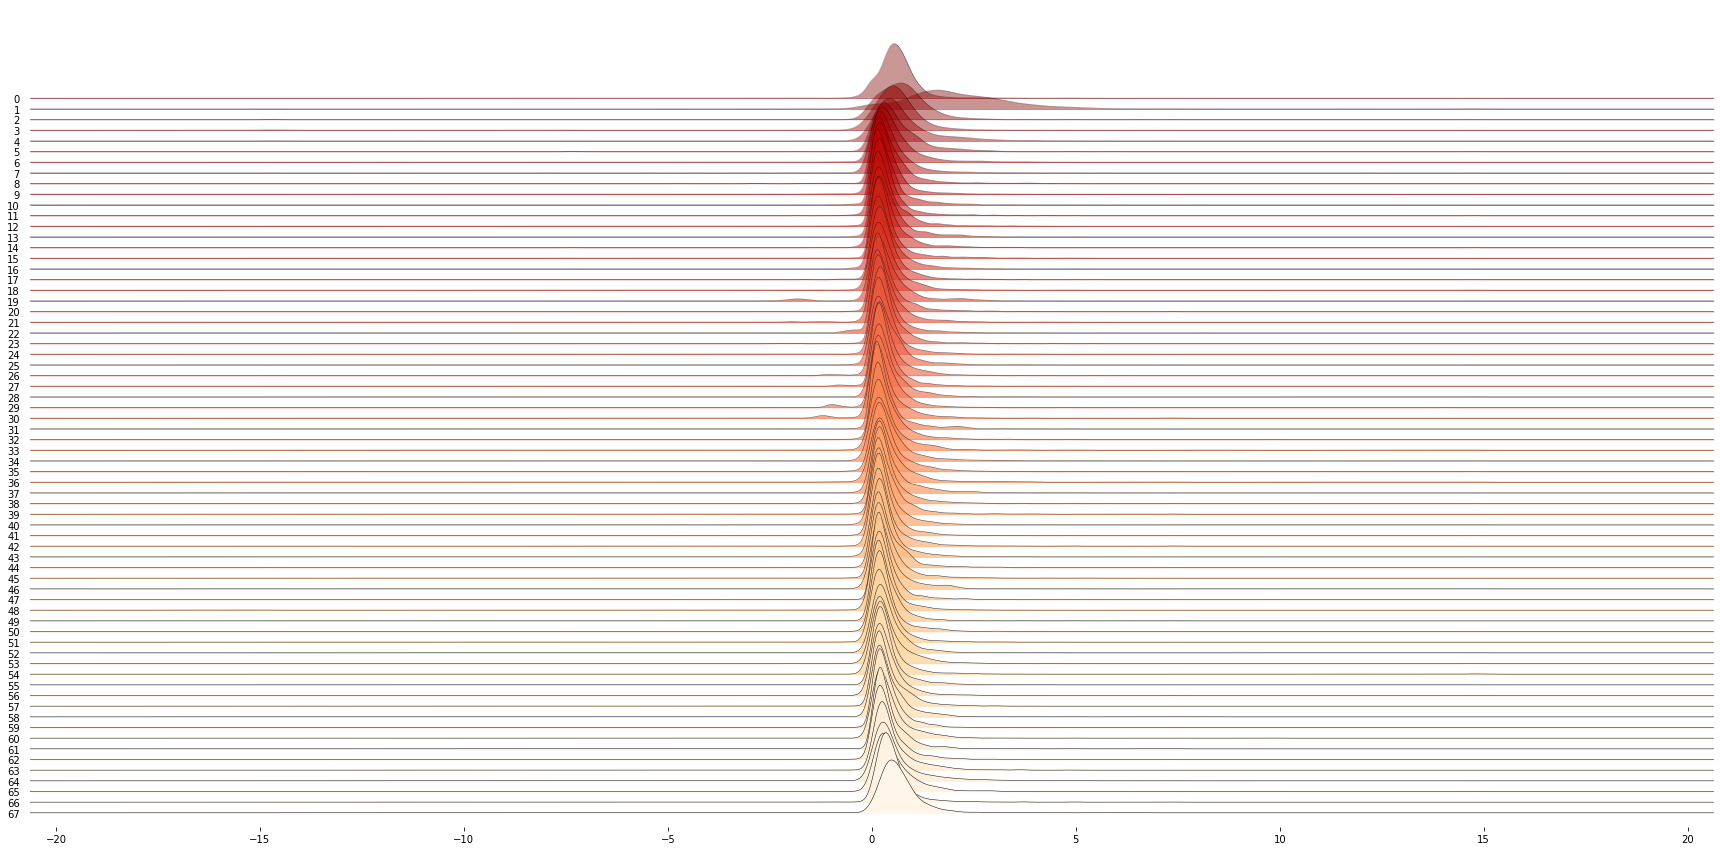

deg_pH10


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,2.005138,2.923601,0.928780,0.722546,0.740868,0.680899,0.571747,0.461096,0.452307,0.409445,...,0.407300,0.394559,0.457730,0.422139,0.432254,0.467999,0.468921,0.467846,0.453545,0.941840
std,1.389639,1.971613,2.163162,3.686616,1.112438,0.744950,1.076637,1.208064,0.658808,1.409217,...,0.612997,1.128074,1.461789,0.959858,1.895334,1.551564,0.707833,0.752139,1.821176,1.996348
min,-44.515300,-44.515300,-44.506400,-44.506400,-44.515300,-22.261000,-44.515300,-44.515300,-8.904500,-7.420500,...,-3.180300,-22.255400,-7.035000,-4.047600,-44.515300,-14.840400,-3.091800,-3.180300,-44.515300,-33.384800
25%,1.623325,2.115600,0.593800,0.491475,0.427400,0.340600,0.246425,0.174750,0.146725,0.120225,...,0.116850,0.121200,0.127375,0.123825,0.121250,0.139875,0.155050,0.169450,0.189300,0.420975
50%,2.031450,2.885650,0.984550,0.701650,0.660500,0.605600,0.466450,0.376300,0.349350,0.271400,...,0.281950,0.268400,0.280000,0.266900,0.268850,0.287900,0.339850,0.353250,0.344900,0.724300
75%,2.476300,3.673350,1.294575,0.978650,0.987975,0.939775,0.789125,0.651800,0.632425,0.523500,...,0.543000,0.538825,0.549200,0.525775,0.509175,0.544675,0.585700,0.598050,0.554525,1.138825
max,14.840400,44.515300,44.515300,44.506400,11.125500,8.904700,4.947000,11.880700,8.098800,44.519700,...,14.840400,44.515300,44.515300,22.259900,44.519700,44.515300,14.840400,14.840400,44.515300,44.519700


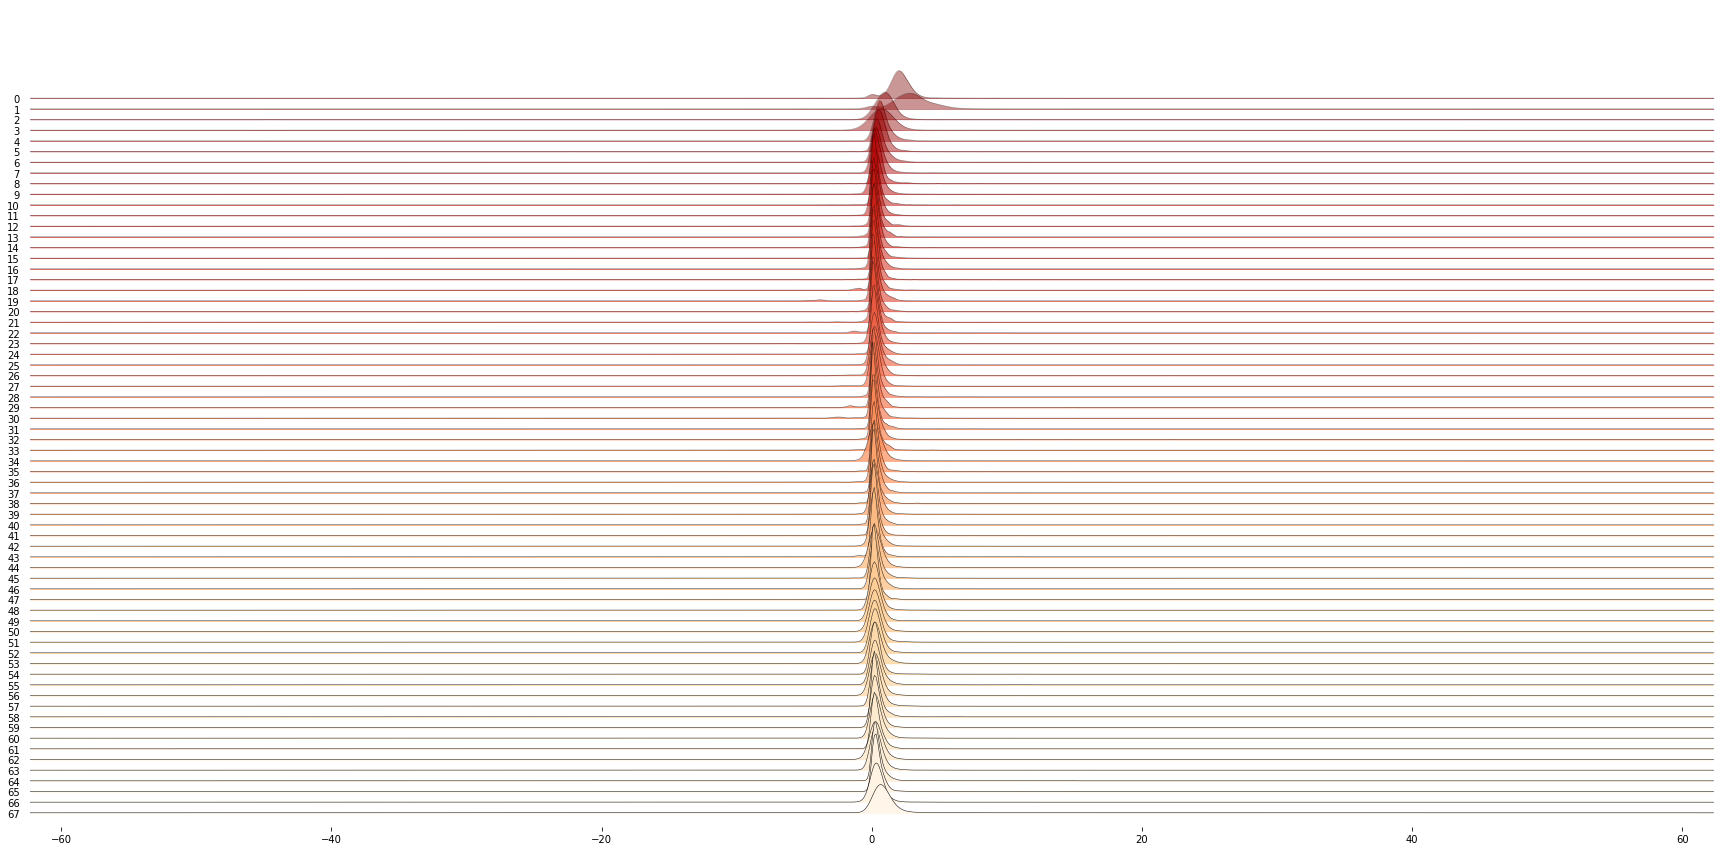

deg_Mg_50C


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.476655,2.033298,0.962429,0.747399,0.856011,0.623050,0.511681,0.432986,0.449736,0.354612,...,0.369458,0.355625,0.385201,0.357709,0.368206,0.480367,0.563445,0.573512,0.501915,0.469470
std,0.817809,1.616327,1.366489,2.102038,1.272135,0.663876,0.807334,0.942428,0.627217,0.492738,...,0.505450,0.755721,0.887452,0.456296,0.722366,0.833200,0.844278,0.702878,1.129472,1.053621
min,-24.252500,-24.252500,-24.247600,-24.252500,-24.252500,-12.128100,-24.252500,-24.252500,-4.851300,-4.042800,...,-4.198100,-24.252500,-24.252500,-2.205200,-20.209700,-8.085200,-0.826900,-3.465200,-24.252500,-24.252500
25%,0.298100,1.249325,0.523250,0.526800,0.381225,0.218450,0.152450,0.090600,0.079300,0.066600,...,0.080600,0.086375,0.077150,0.076950,0.078075,0.114075,0.142050,0.180150,0.222250,0.236100
50%,0.463300,1.839200,0.989600,0.801150,0.685150,0.477400,0.354100,0.289900,0.280450,0.239750,...,0.250450,0.257950,0.249900,0.231050,0.236200,0.296800,0.373250,0.420800,0.404900,0.380900
75%,0.630325,2.739650,1.372250,1.084875,1.097900,0.894625,0.699950,0.626275,0.631800,0.496425,...,0.513325,0.498900,0.528725,0.513975,0.508550,0.632100,0.698575,0.788700,0.607100,0.587000
max,24.247600,24.252500,12.126200,24.252500,24.252500,9.096300,12.127500,24.252500,10.237700,6.064200,...,8.085200,12.127500,24.252500,8.085200,12.128100,24.252500,24.252500,12.127500,24.252500,24.252500


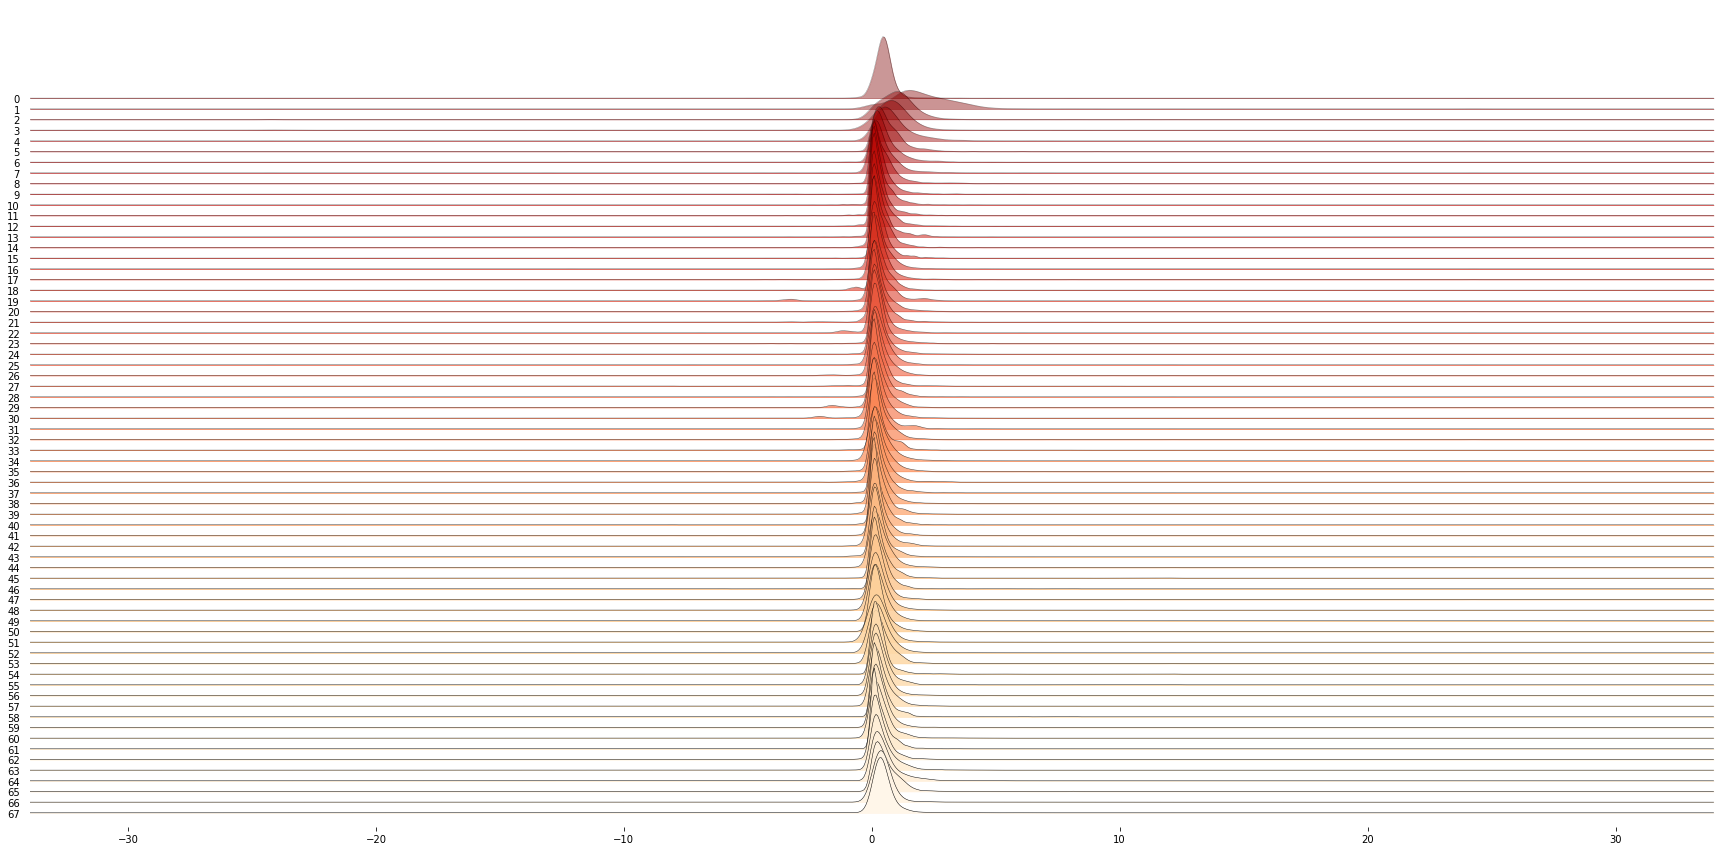

deg_50C


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.612250,1.803313,1.019534,0.765357,0.746606,0.627279,0.562147,0.481785,0.484335,0.433881,...,0.393853,0.349833,0.360787,0.377142,0.391510,0.421597,0.458241,0.533046,0.462601,0.598597
std,0.955351,1.546547,1.921599,2.784339,1.239240,0.666092,1.076317,1.380732,0.742647,0.913521,...,0.945835,0.993586,1.004240,0.653856,1.340709,0.965946,1.253718,1.564194,1.568287,1.984896
min,-38.339900,-38.339900,-38.332300,-38.332300,-38.339900,-19.172900,-38.339900,-38.339900,-6.372400,-6.391100,...,-4.260800,-38.339900,-38.339900,-1.783600,-38.339900,-12.781700,-4.793300,-5.478100,-38.339900,-38.339900
25%,0.428725,1.257350,0.693200,0.590800,0.437250,0.286900,0.192675,0.124375,0.113450,0.098150,...,0.086450,0.088775,0.091575,0.092250,0.098600,0.116050,0.133350,0.180525,0.186450,0.282000
50%,0.630100,1.737450,1.059200,0.864600,0.699400,0.560850,0.446050,0.390200,0.373250,0.303600,...,0.308800,0.284700,0.290100,0.273150,0.288600,0.323200,0.333150,0.383550,0.365250,0.483250
75%,0.819225,2.351400,1.396425,1.138850,1.022000,0.871950,0.826575,0.732525,0.716725,0.643400,...,0.546925,0.520825,0.530650,0.522675,0.554925,0.574275,0.583400,0.646200,0.564400,0.720525
max,7.669200,38.332300,38.339900,38.339900,19.170000,5.899500,19.171900,38.339900,11.502700,34.497600,...,38.339900,9.586800,19.171900,19.173200,38.339900,38.339900,38.339900,38.343800,38.343800,38.343800


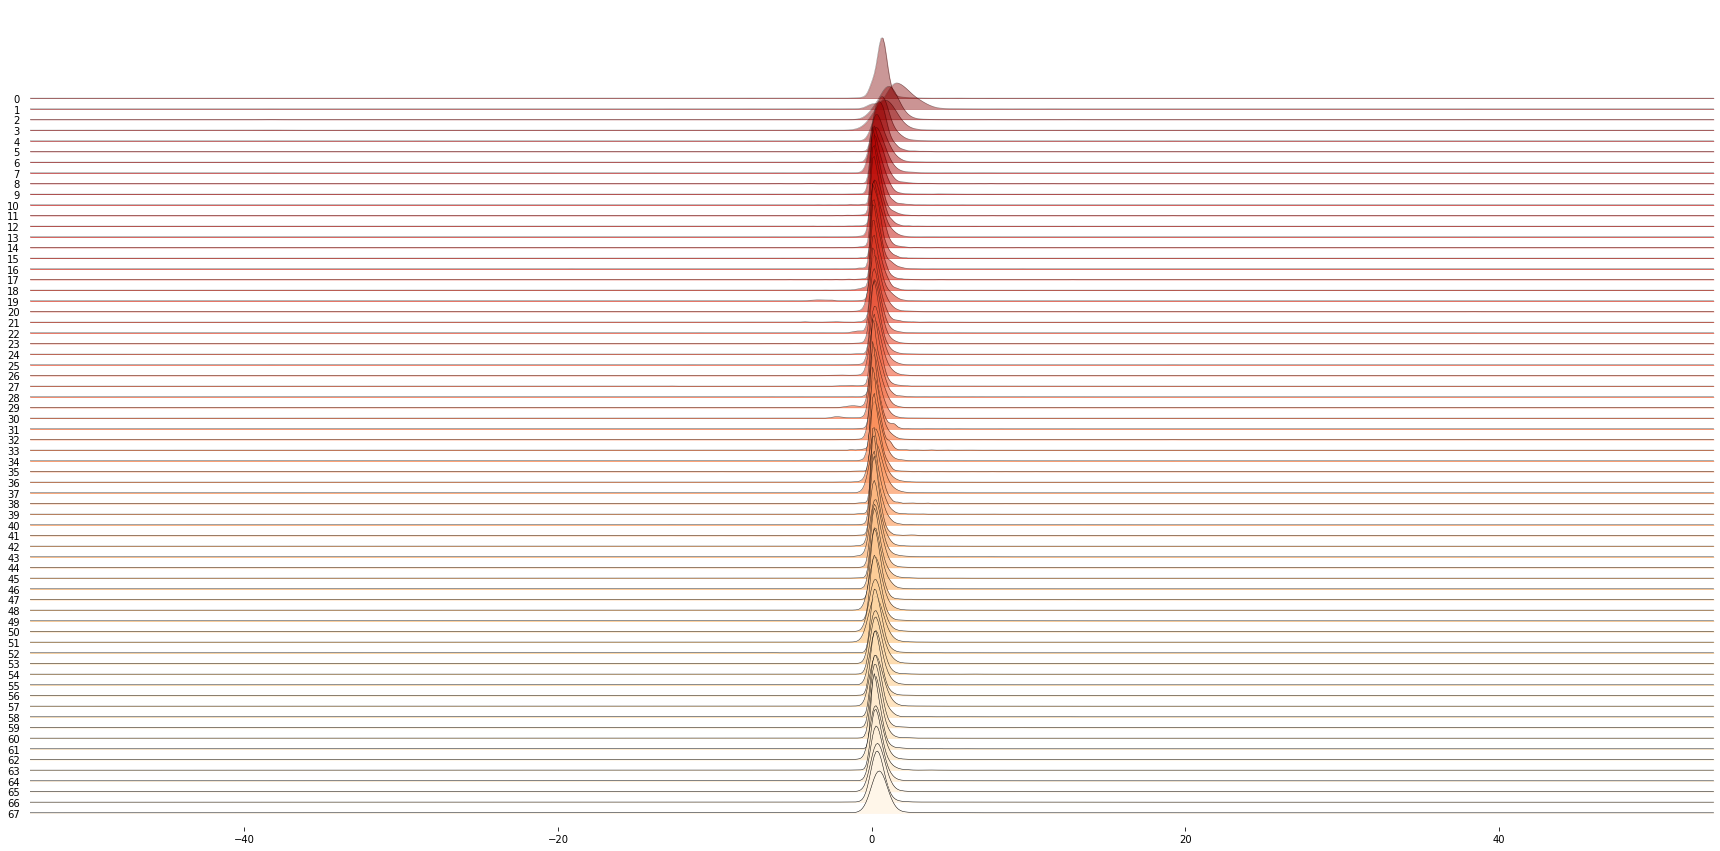

In [24]:
for normal_label_name in NORMAL_LABEL_NAMES:
    column = raw_train_valid_ds[normal_label_name]
    print(f"{normal_label_name}")
    visualize_column(column)

### Raw examples visualization

In [25]:
def draw_raw_example(example, **kwargs):
    sequence = example['sequence']
    structure = example['structure']
    seq_length = example['seq_length']
    seq_scored = example['seq_scored']
    seq_not_scored = seq_length - seq_scored
    draw_struct(sequence, structure, alpha = np.concatenate([np.ones(seq_scored),0.3*np.ones(seq_not_scored)]), **kwargs)
    
def draw_random_raw_examples(raw_ds, examples_no=5):
    example_indices = random.sample(range(len(raw_ds)), examples_no)
    plot_size = 15
    fig, axes = plt.subplots(1,examples_no,figsize=(plot_size*examples_no,plot_size))
    for i, ax in enumerate(axes.flat):
        draw_raw_example(raw_ds.iloc[example_indices[i],:], ax=ax)

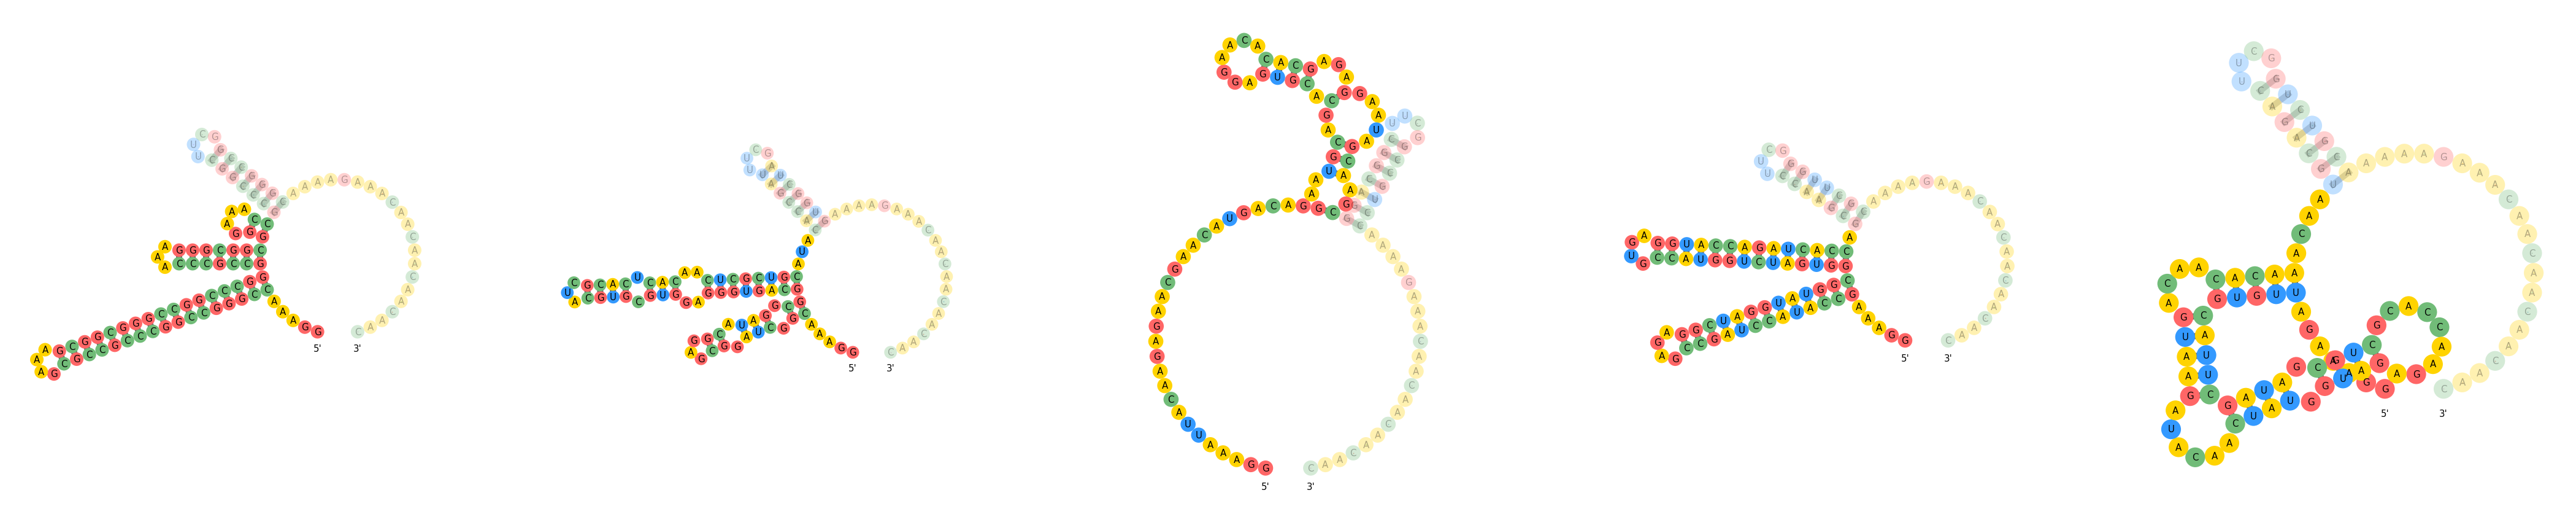

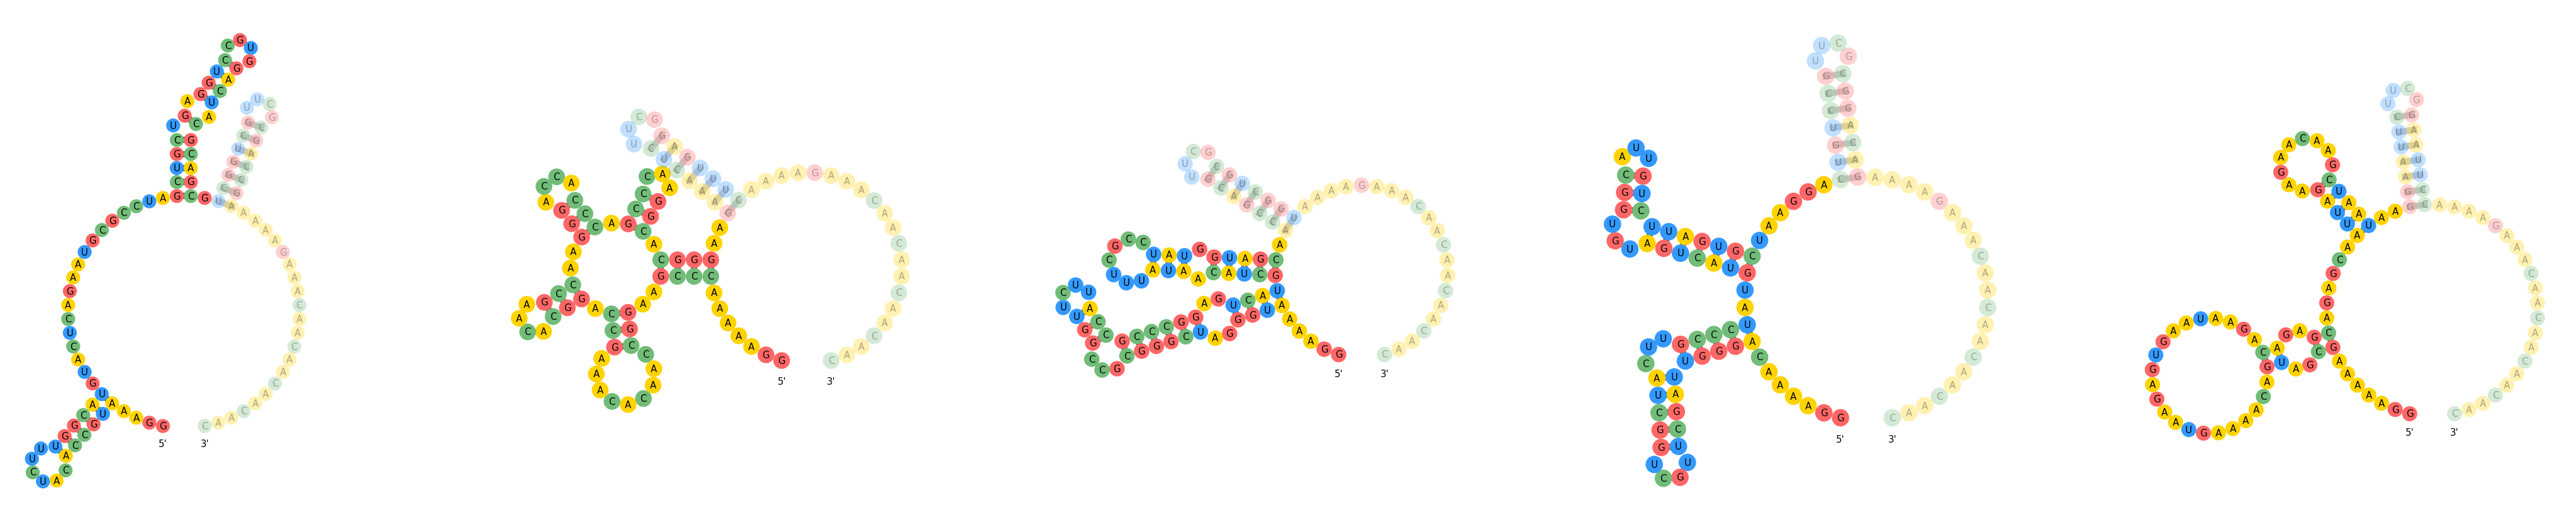

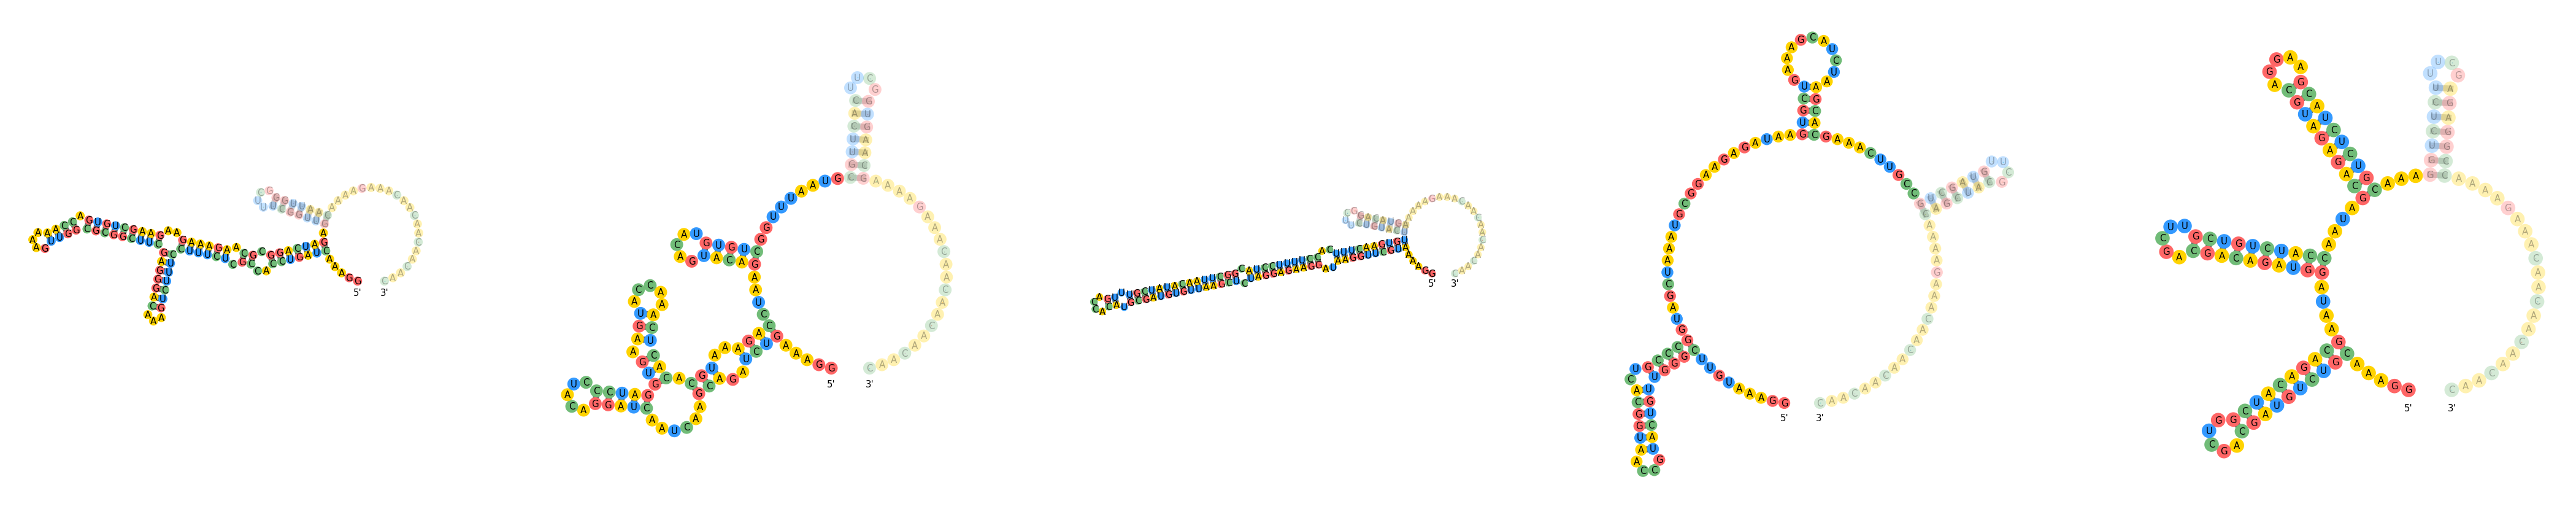

In [26]:
draw_random_raw_examples(raw_train_valid_ds)
draw_random_raw_examples(raw_public_test_ds)
draw_random_raw_examples(raw_private_test_ds)

# Structured tf.data.Dataset construction

In [27]:
train_valid_ds, public_test_ds, private_test_ds = convert_to_datasets(raw_train_valid_ds, raw_public_test_ds, raw_private_test_ds)

### Inspect tf.data.Dataset's
Output is quite long so uncomment if needed

In [28]:
# ds_summary(train_valid_ds, 'public_test_ds')

In [29]:
# ds_summary(public_test_ds, 'public_test_ds')

In [30]:
# ds_summary(private_test_ds, 'public_test_ds')

# Model

In [31]:
print(f"feature_names: {FEATURE_NAMES}")
print(f"error_label_names: {ERROR_LABEL_NAMES}")
print(f"normal_label_names: {NORMAL_LABEL_NAMES}")
print(f"all_label_names: {ALL_LABEL_NAMES}")
print(f"scored_label_names: {SCORED_LABEL_NAMES}")

feature_names: ['sequence', 'structure', 'predicted_loop_type', 'adjacency_matrix']
error_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
normal_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
all_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
scored_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']


# Main Model

In [32]:
# INPUTS
INPUT_SEQUENCE_LENGTH = None
sequence_input = Input(shape=(INPUT_SEQUENCE_LENGTH,4),
                       name='sequence')
structure_input = Input(shape=(INPUT_SEQUENCE_LENGTH,3),
                        name='structure')
predicted_loop_type_input = Input(shape=(INPUT_SEQUENCE_LENGTH,7),
                                  name='predicted_loop_type')

inputs = [sequence_input, structure_input, predicted_loop_type_input]

# ACTUAL MODEL
# Stack inputs
stacked_inputs = Concatenate(axis=2, name='input_stacking_layer')(inputs)

vectors_sequence = TimeDistributed(Dense(128), name='vectors_expander')(stacked_inputs)

# Encoder
encoder_LSTM = LSTM(256, return_state=True, name='encoder_LSTM')
_, state_h, state_c = encoder_LSTM(vectors_sequence)

# state_h = Dense(256, activation='relu', name='dense_between_1_h')(state_h)
# state_c = Dense(256, activation='relu', name='dense_between_1_c')(state_c)

# state_h = Dense(256, activation='relu', name='dense_between_2_h')(state_h)
# state_c = Dense(256, activation='relu', name='dense_between_2_c')(state_c)

# Decoder
# decoder_LSTM = SequenceGenerator(tf.keras.layers.LSTM(256, name='decoder_LSTM'), seq_len=68, name='decoder')
# decoder_outputs = decoder_LSTM(initial_state=[state_h, state_c])

decoder_LSTM = LSTM(256, name='decoder_LSTM', return_sequences=True)
decoder_outputs = decoder_LSTM(vectors_sequence, initial_state=[state_h, state_c])

# Dense layers
x = TimeDistributed(Dense(256, activation='relu', name='dense_1'))(decoder_outputs)
x = TimeDistributed(Dense(256, activation='relu', name='dense_2'))(x)

# OUTPUTS
reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
# reactivity_error_pred = TimeDistributed(Dense(1), name='reactivity_error')(x)

deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
# deg_error_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_error_Mg_pH10')(x)

# deg_pH10_pred = TimeDistributed(Dense(1), name='deg_pH10')(x)
# deg_error_pH10_pred = TimeDistributed(Dense(1), name='deg_error_pH10')(x)

deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)
# deg_error_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_error_Mg_50C')(x)

# deg_50C_pred = TimeDistributed(Dense(1), name='deg_50C')(x)
# deg_error_50C_pred = TimeDistributed(Dense(1), name='deg_error_50C')(x)


# all_outputs = [reactivity_pred, reactivity_error_pred,
#                deg_Mg_pH10_pred, deg_error_Mg_pH10_pred,
#                deg_pH10_pred, deg_error_pH10_pred,
#                deg_Mg_50C_pred, deg_error_Mg_50C_pred,
#                deg_50C_pred, deg_error_50C_pred]

# submission_required_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred, deg_pH10_pred, deg_50C_pred]

scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
stacked_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)

# TESTING MODEL
testing_model = Model(inputs=inputs, outputs={'stacked_scored_labels': stacked_outputs}, name='testing_model')

# TRAINING MODEL
training_scored_seq_len = 68
# trimmed_stacked_outputs = tf.slice(stacked_outputs, begin=[0,0,0], size=[-1,training_scored_seq_len, -1])
trimmed_stacked_outputs = Lambda(lambda x: x[:,:training_scored_seq_len], name='trimming_layer')(stacked_outputs)
training_model = Model(inputs=inputs, outputs={'stacked_scored_labels': trimmed_stacked_outputs}, name='training_model')

# Graph neural network model

In [33]:
# INPUTS
INPUT_SEQUENCE_LENGTH = None
sequence_input = Input(shape=(INPUT_SEQUENCE_LENGTH,4),
                       name='sequence')
structure_input = Input(shape=(INPUT_SEQUENCE_LENGTH,3),
                        name='structure')
predicted_loop_type_input = Input(shape=(INPUT_SEQUENCE_LENGTH,7),
                                  name='predicted_loop_type')

adjacency_matrix_input = Input(shape=(None, None), name='adjacency_matrix')

inputs = [sequence_input, structure_input, predicted_loop_type_input, adjacency_matrix_input]

features_to_stack = [sequence_input, structure_input, predicted_loop_type_input]
features_input = Concatenate(axis=2, name='input_stacking_layer')(features_to_stack)

# ACTUAL MODEL
# Stack inputs

# Embedding
vectors_sequence = TimeDistributed(Dense(128), name='vectors_expander')(features_input)

# Graph block
graph_layer_1 = GraphAttention(512, activation='relu')
x = graph_layer_1([vectors_sequence, adjacency_matrix_input])

graph_layer_2 = GraphAttention(512, activation='relu')
x = graph_layer_2([x, adjacency_matrix_input])

graph_layer_3 = GraphAttention(256, activation='relu')
x = graph_layer_3([x, adjacency_matrix_input])

graph_layer_4 = GraphAttention(256, activation='relu')
graph_output = graph_layer_4([x, adjacency_matrix_input])

# OUTPUTS
# reactivity_pred = GraphAttention(1, name='reactivity')([x, adjacency_matrix_input])
# deg_Mg_pH10_pred = GraphAttention(1,name='deg_Mg_pH10')([x, adjacency_matrix_input])
# deg_Mg_50C_pred = GraphAttention(1, name='deg_Mg_50C')([x, adjacency_matrix_input])

# Encoder decoder block
# Encoder
encoder_LSTM = LSTM(256, return_state=True, name='encoder_LSTM')
_, state_h, state_c = encoder_LSTM(vectors_sequence)

# Decoder
decoder_LSTM = LSTM(256, name='decoder_LSTM', return_sequences=True)
decoder_outputs = decoder_LSTM(vectors_sequence, initial_state=[state_h, state_c])

# Dense layers
x = TimeDistributed(Dense(256, activation='relu', name='dense_1'))(decoder_outputs)
enc_dec_output = TimeDistributed(Dense(256, activation='relu', name='dense_2'))(x)

# Branch merging
concat_outputs = Concatenate(axis=2, name='branch_merger')([graph_output, enc_dec_output])

reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(concat_outputs)
deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(concat_outputs)
deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(concat_outputs)

# Outputs
scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
stacked_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)

# TESTING MODEL
testing_model = Model(inputs=inputs, outputs={'stacked_scored_labels': stacked_outputs}, name='testing_model')

# TRAINING MODEL
training_scored_seq_len = 68
# trimmed_stacked_outputs = tf.slice(stacked_outputs, begin=[0,0,0], size=[-1,training_scored_seq_len, -1])
trimmed_stacked_outputs = Lambda(lambda x: x[:,:training_scored_seq_len], name='trimming_layer')(stacked_outputs)
training_model = Model(inputs=inputs, outputs={'stacked_scored_labels': trimmed_stacked_outputs}, name='training_model')

In [34]:
testing_model.summary()
print('\n\n\n\n\n')
training_model.summary()

Model: "testing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
structure (InputLayer)          [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
predicted_loop_type (InputLayer [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
input_stacking_layer (Concatena (None, None, 14)     0           sequence[0][0]                   
                                                                 structure[0][0]      

Submissions are scored using MCRMSE (mean columnwise root mean squared error):
$\textrm{MCRMSE} = \frac{1}{N_{t}}\sum_{j=1}^{N_{t}}\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{ij} - \hat{y}_{ij})^2}$

In [35]:
def mcrmse(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse, axis=1)

In [36]:
training_model.compile(loss=mcrmse,
#               optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9),
              optimizer='adam')

testing_model.compile(loss=mcrmse)

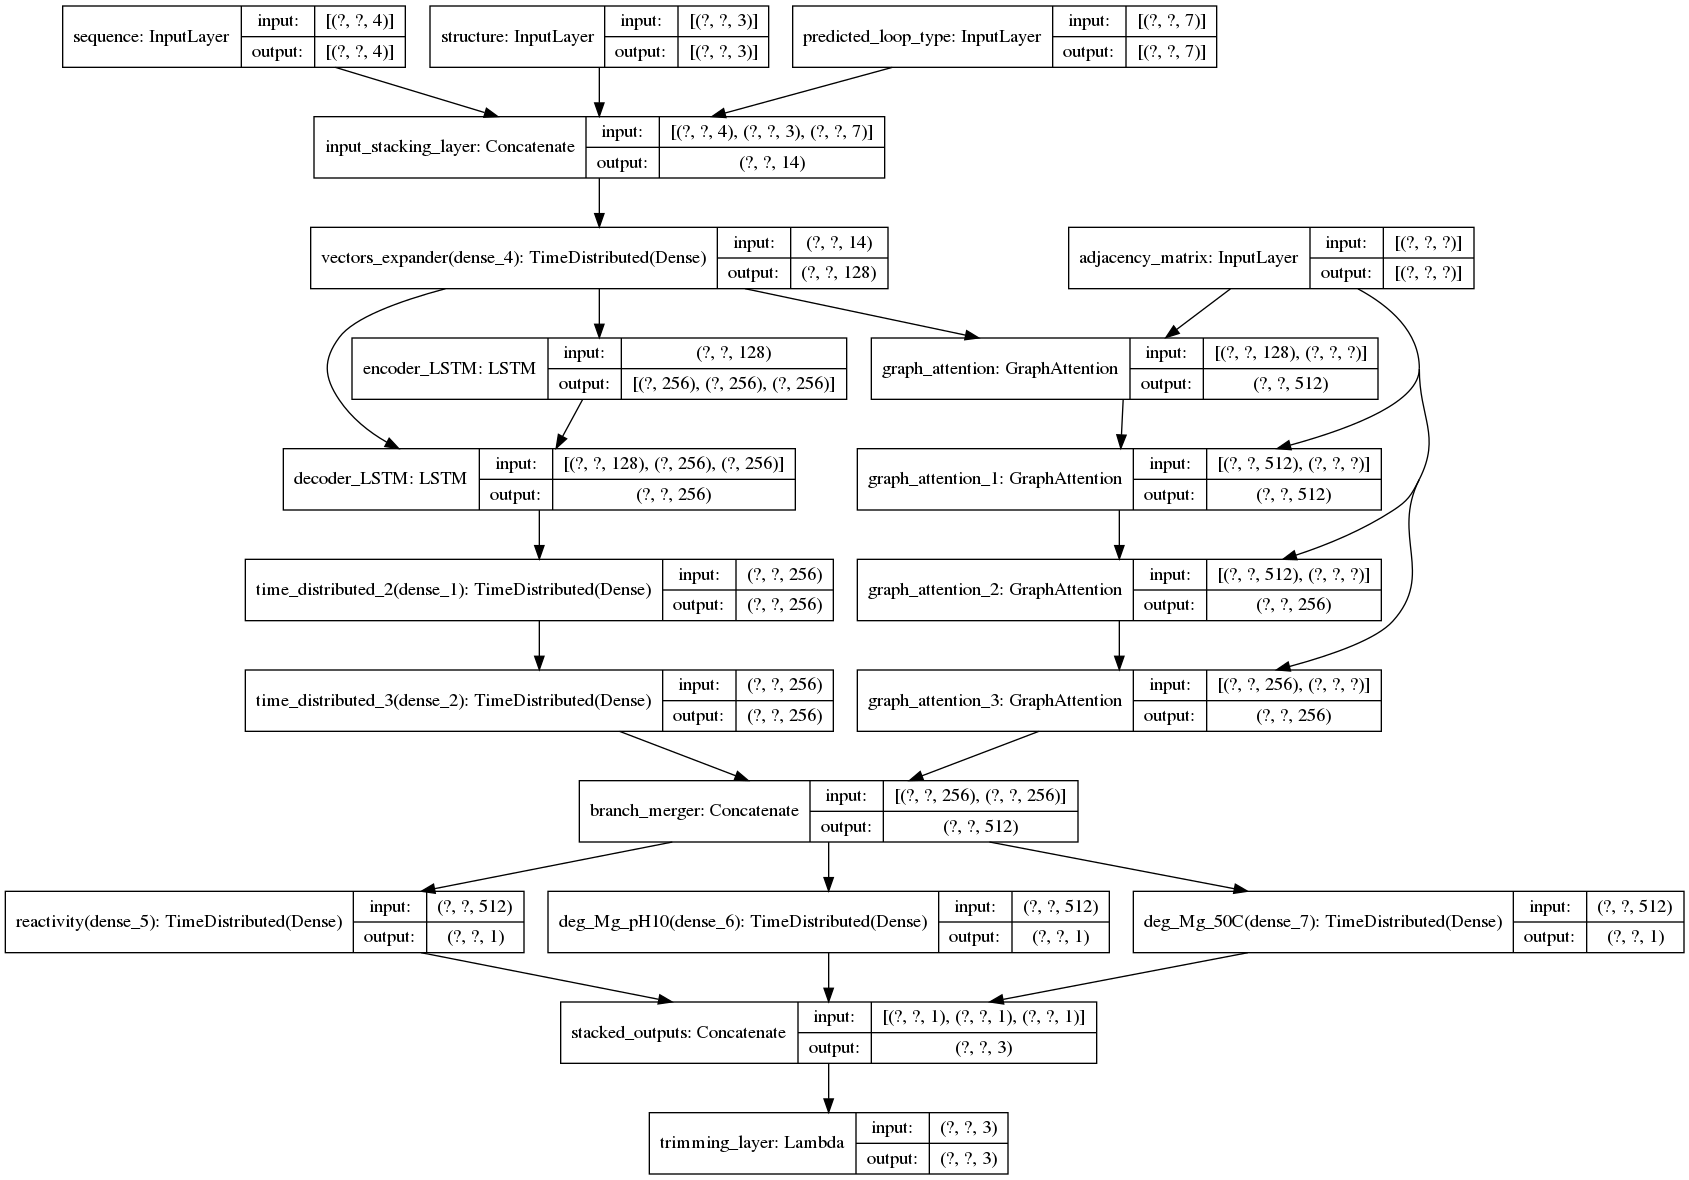

In [37]:
tf.keras.utils.plot_model(training_model, show_shapes=True)

In [38]:
# tf.keras.utils.plot_model(testing_model, show_shapes=True)

# Additional dataset preparations

In [39]:
def only_stacked_scored_labels(x, y):
    tensors_to_stack = [y[scored_label] for scored_label in SCORED_LABEL_NAMES]
    stacked_scored_labels = tf.stack(tensors_to_stack, axis=1)
    y = {'stacked_scored_labels': stacked_scored_labels}
    return x, y

In [40]:
train_valid_with_stacked_labels_ds = train_valid_ds.map(only_stacked_scored_labels)

In [41]:
def split_into_train_and_valid(train_valid_ds, split_factor=0.3):
    lenght = train_valid_ds.cardinality().numpy()
    valid_ds_length = int(split_factor*lenght)
    train_valid_ds_shuffled = train_valid_ds.shuffle(lenght)
    train_ds = train_valid_ds_shuffled.skip(valid_ds_length)
    valid_ds = train_valid_ds_shuffled.take(valid_ds_length)
    return train_ds, valid_ds

In [42]:
train_ds, valid_ds = split_into_train_and_valid(train_valid_with_stacked_labels_ds, split_factor=0.3)

In [43]:
print(train_ds.cardinality())
print(train_ds)

tf.Tensor(1680, shape=(), dtype=int64)
<SkipDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7), adjacency_matrix: (107, 107)}, {stacked_scored_labels: (68, 3)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32, adjacency_matrix: tf.float32}, {stacked_scored_labels: tf.float32})>


In [44]:
print(valid_ds.cardinality())
print(valid_ds)

tf.Tensor(720, shape=(), dtype=int64)
<TakeDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7), adjacency_matrix: (107, 107)}, {stacked_scored_labels: (68, 3)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32, adjacency_matrix: tf.float32}, {stacked_scored_labels: tf.float32})>


In [45]:
print(public_test_ds.cardinality())
print(public_test_ds)

tf.Tensor(629, shape=(), dtype=int64)
<TensorSliceDataset shapes: {sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7), adjacency_matrix: (107, 107)}, types: {sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32, adjacency_matrix: tf.float32}>


In [46]:
print(private_test_ds.cardinality())
print(private_test_ds)

tf.Tensor(3005, shape=(), dtype=int64)
<TensorSliceDataset shapes: {sequence: (130, 4), structure: (130, 3), predicted_loop_type: (130, 7), adjacency_matrix: (130, 130)}, types: {sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32, adjacency_matrix: tf.float32}>


### Baseline training and testing models evaluation

In [47]:
def trim(x,y):
    for label in x.keys():
        x[label] = x[label][:68,:]
    for label in y.keys():
        y[label] = y[label][:68,:]
    return x,y

In [48]:
training_model.evaluate(valid_ds.batch(64))

12/12 [==============================] - 0s 16ms/step - loss: 0.6959


0.6959440112113953

# Model training

In [50]:
log_dir = os.path.join(os.getcwd(), 'logs')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, update_freq='epoch')

In [51]:
history = training_model.fit(train_ds.batch(128),
          validation_data=valid_ds.batch(128),
          epochs=100,
          initial_epoch=1,
          verbose=0,
          shuffle=True,
          callbacks=[tensorboard_callback])

KeyboardInterrupt: 

In [52]:
%tensorboard --logdir $log_dir

### training and testing model evaluation

In [53]:
training_model.evaluate(valid_ds.batch(64))

12/12 [==============================] - 0s 16ms/step - loss: 0.6442


0.6442236304283142

In [54]:
testing_model.evaluate(valid_ds.batch(64))

ValueError: in user code:

    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    <ipython-input-35-6c62d5a29993>:2 mcrmse  *
        rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1140 binary_op_wrapper
        raise e
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1124 binary_op_wrapper
        return func(x, y, name=name)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:526 subtract
        return gen_math_ops.sub(x, y, name)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:10466 sub
        "Sub", x=x, y=y, name=name)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 68 and 107 for '{{node mcrmse/sub}} = Sub[T=DT_FLOAT](IteratorGetNext:4, testing_model/stacked_outputs/concat)' with input shapes: [?,68,3], [?,107,3].


### Shape sanity checks

In [63]:
def get_predictions(ds, model):
    prediction_ds = ds.batch(64)
    predictions = model.predict(prediction_ds)['stacked_scored_labels']
    return predictions

In [77]:
predictions_1 = get_predictions(train_ds, training_model)
print(predictions_1.shape)

(1680, 68, 3)


In [78]:
# WRONG USAGE - FOR SANITY CHECK ONLY
predictions_2 = get_predictions(train_ds, testing_model)
print(predictions_2.shape)

(1680, 107, 3)


In [79]:
predictions_3 = get_predictions(public_test_ds, testing_model)
print(predictions_3.shape)

(629, 107, 3)


In [80]:
# WRONG USAGE - FOR SANITY CHECK ONLY
predictions_4 = get_predictions(public_test_ds, training_model)
print(predictions_4.shape)

(629, 68, 3)


In [81]:
predictions_5 = get_predictions(private_test_ds, testing_model)
print(predictions_5.shape)

(3005, 130, 3)


In [69]:
# WRONG USAGE - FOR SANITY CHECK ONLY
predictions_6 = get_predictions(private_test_ds, training_model)
print(predictions_6.shape)

(3005, 68, 3)


### Important Note

Training and testing models share same layers. The difference is that training model has fixed output sequence length (68) due to training - it has to be this.
On the other hand testing model output_sequence length is equal to the input sequence length.
So the training model is used the training and testing model benefits from it. Moreover testing model allows to create submissions.

Submission containes predictions for all positions in sequences. Moreover it contains two parts:
- submission created out of public test set - seqlen: 107, scoring length: 68
- submission created out of private test set - seqlen: 130, scoring length: 91
Testing model is able to create predictions for both public and private test set because it has not set sequence dimension

# Create submission

In [57]:
submission = create_submission(testing_model, [public_test_ds, private_test_ds], [raw_public_test_ds, raw_private_test_ds])
submission

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.157416,0.186757,0.0,0.083496,0.0
1,id_00073f8be_1,0.154578,0.208136,0.0,0.083176,0.0
2,id_00073f8be_2,0.144321,0.238697,0.0,0.090650,0.0
3,id_00073f8be_3,0.136249,0.262321,0.0,0.093006,0.0
4,id_00073f8be_4,0.138621,0.279781,0.0,0.099233,0.0
...,...,...,...,...,...,...
457948,id_ffda94f24_125,0.183806,0.365661,0.0,0.146426,0.0
457949,id_ffda94f24_126,0.185073,0.359882,0.0,0.147423,0.0
457950,id_ffda94f24_127,0.186090,0.364006,0.0,0.146511,0.0
457951,id_ffda94f24_128,0.184597,0.368365,0.0,0.146741,0.0


In [61]:
submission_name = 'submission.csv'
submission_path = os.path.join(os.getcwd(), submission_name)
submission.to_csv(submission_path, header=True, index=False)

# Model saving and loading

In [130]:
training_model_file_name = 'training_model'
training_model_path = os.path.join(os.getcwd(), training_model_file_name)

testing_model_file_name = 'testing_model'
testing_model_path = os.path.join(os.getcwd(), testing_model_file_name)

In [137]:
training_model = tf.keras.models.load_model(training_model_path, custom_objects={'mcrmse': mcrmse})
testing_model = tf.keras.models.load_model(testing_model_path, custom_objects={'mcrmse': mcrmse})

In [152]:
# training_model.save(training_model_path)
# testing_model.save(testing_model_path)

INFO:tensorflow:Assets written to: training_model/assets
INFO:tensorflow:Assets written to: testing_model/assets


TODO:
* cross-validation - more data to train
* signal_to_noise parameter - maybe it can be used in some way
* unsupervised pretraining - wuju ogarnia
* SequenceGenerator:
    - propably delete it, but if not:
    - SequenceGenerator wrapper fix get_config
    - SequenceGenerator fix rnn.units handling in case of nested wrapper (e.g. Bidirectional)